# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Notwendige Funktionen

In [209]:
def fft_peaks(a, peaks=None):
    # fast fourier analysis and return n-peak
    n = a.size
    a_z_without_mean = a - np.mean(a)
    yfreq = np.fft.rfft(a_z_without_mean, n, norm='ortho')
    yfreq = np.abs(yfreq)
    yfreq[0] = 0.0
    if peaks == None:
        peaks = len(yfreq)
    yfreq[yfreq < sorted(yfreq, reverse=True)[:peaks][-1:]] = 0
    return yfreq#sorted(yfreq, reverse=True)[:peaks]

def chunker(seq, size=64):
    # splitting df in chunk of size
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

chunk_length = 64
label_column = "Trommel"

def transform(df):
    fft_data = []
    fft_labels=[]
    #df = df.drop(columns=[0])
    for chunk in chunker(df, chunk_length):
        if label_column in chunk.columns.values:
            labels = chunk[label_column].value_counts()
            if len(labels) > 0:
                label = chunk[label_column].value_counts().index[0]
                fft_data.append(fft_peaks(chunk["A"]))
                fft_labels.append(label)
        else:
            fft_data.append(fft_peaks(chunk["A"]))
    df_fft = pd.DataFrame.from_dict(fft_data).dropna()
    return df_fft

# Import & Vorbereitung der Daten

In [123]:
df = pd.read_csv("ml_training_backup")
df = df[df["Waschprogramm"] != "Default"]

df["A"] = np.sqrt(df["AX"]**2 + df["AY"]**2 + df["AZ"]**2)

df_trommel_stillstand = df[df["Trommel"] == 0]
df_trommel_rotieren = df[df["Trommel"] == 1]
df_trommel_schleudern = df[df["Trommel"] == 2]

df_pumpe_aus = df[df["Pumpe"] == 0]
df_pumpe_an = df[df["Pumpe"] == 1]

df_betriebszustand_bereit = df[df["Betriebszustand"] == 0]
df_betriebszustand_waschen = df[df["Betriebszustand"] == 1]
df_betriebszustand_spuelen = df[df["Betriebszustand"] == 2]
df_betriebszustand_schleudern = df[df["Betriebszustand"] == 3]

datasets_trommel = {0:df_trommel_stillstand, 1:df_trommel_rotieren, 2:df_trommel_schleudern}
datasets_pumpe = {0:df_pumpe_an, 1:df_pumpe_aus}
datasets_betriebszustand = {0:df_betriebszustand_bereit, 
                            1:df_betriebszustand_waschen,
                            2:df_betriebszustand_spuelen,
                            3:df_betriebszustand_schleudern}

df_fft_trommel = create_fft_df(datasets_trommel)
#df_fft_pumpe = create_fft_df(datasets_pumpe)
#df_fft_betriebszustand = create_fft_df(datasets_betriebszustand)


Text(0, 0.5, 'FFT(T)')

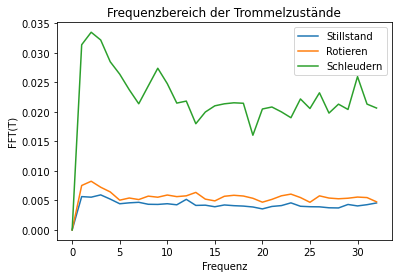

In [222]:
df_trommel_stillstand_fft = transform(df_trommel_stillstand)
df_trommel_rotieren_fft = transform(df_trommel_rotieren)
df_trommel_schleudern_fft = transform(df_trommel_schleudern)

df_trommel_fft = pd.concat([df_trommel_stillstand_fft.mean(), 
                            df_trommel_rotieren_fft.mean(), 
                            df_trommel_schleudern_fft.mean()], axis=1)

df_trommel_fft.columns=["Stillstand", "Rotieren", "Schleudern"]

df_trommel_fft.plot()
plt.title("Frequenzbereich der Trommelzustände")
plt.xlabel("Frequenz")
plt.ylabel("FFT(T)")


Text(0, 0.5, 'FFT(T)')

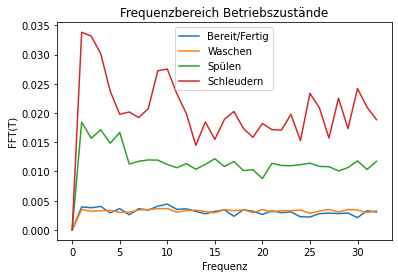

In [214]:
df_betriebszustand_bereit_fft = transform(df_betriebszustand_bereit)
df_betriebszustand_waschen_fft = transform(df_betriebszustand_waschen)
df_betriebszustand_spuelen_fft = transform(df_betriebszustand_spuelen)
df_betriebszustand_schleudern_fft = transform(df_betriebszustand_schleudern)

df_betriebszustand_fft = pd.concat([df_betriebszustand_bereit_fft.mean(), 
                            df_betriebszustand_waschen_fft.mean(), 
                            df_betriebszustand_spuelen_fft.mean(), 
                            df_betriebszustand_schleudern_fft.mean(), 
                           ], axis=1)

df_betriebszustand_fft.columns=["Bereit/Fertig", "Waschen", "Spülen", "Schleudern"]

df_betriebszustand_fft.plot()
plt.title("Frequenzbereich Betriebszustände")
plt.xlabel("Frequenz")
plt.ylabel("FFT(T)")

Text(0, 0.5, 'FFT(T)')

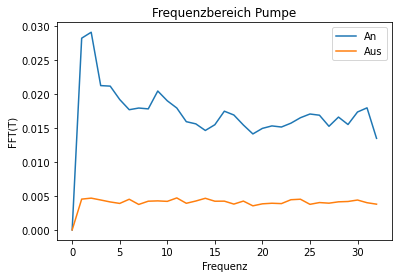

In [212]:
df_pumpe_an_fft = transform(df_pumpe_an)
df_pumpe_aus_fft = transform(df_pumpe_aus)

df_pumpe_fft = pd.concat([df_pumpe_an_fft.mean(), 
                            df_pumpe_aus_fft.mean()], axis=1)

df_pumpe_fft.columns=["An", "Aus"]

df_pumpe_fft.plot()
plt.title("Frequenzbereich Pumpe")
plt.xlabel("Frequenz")
plt.ylabel("FFT(T)")

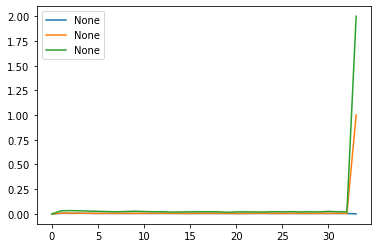

In [185]:
#df_trommel_fft.mean()
df_trommel_stillstand_fft.mean().plot()
df_trommel_rotieren_fft.mean().plot()
df_trommel_schleudern_fft.mean().plot()

plt.legend()

#sns.lineplot(data=df_trommel_fft, x=df_trommel_fft.columns)

In [16]:
df_fft_trommel

""


## 1. Modell Trommel Zustand erkennen

In [172]:
def model(df_fft, classes=[]):
    X = df_fft.drop(columns = [0]).values
    y = df_fft[0].values
    #classes = ["Stillstand", "Rotieren", "Schleudern"]

    # Unterteilung in Test- und Trainingsdaten. 25/75 % Verhältnis
    split_factor=0.25
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_factor, random_state=1, stratify=y)

    # Skalierung der Daten
    scaler = StandardScaler()
    scaler.fit(X_train) # neue Daten müssen mit dem selben Scaler skaliert (.transform) werden. Aufkeinenfall neu fitten.
    X_train_std = scaler.transform(X_train)
    X_test_std = scaler.transform(X_test)
    
    clf = MLPClassifier(alpha=0.03, max_iter=5000, early_stopping=False) #, verbose=True
    clf.fit(X_train_std, y_train)
    
    predicted = clf.predict(X_test_std)
    probabilities = clf.predict_proba(X_test_std)
    score = clf.score(X_test_std, y_test)

    cm = confusion_matrix(y_test, predicted, labels=clf.classes_)
    if classes != None:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)#clf.classes_)
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)#
    disp.plot() 
    return clf, scaler

,0,1
0,0.0,0.002983
1,0.0,0.003021
2,0.0,0.000460
3,0.0,0.000341
4,0.0,0.000271
...,...,...
4670,2.0,2.005894
4671,2.0,2.003141
4672,2.0,2.007946
4673,2.0,2.005679


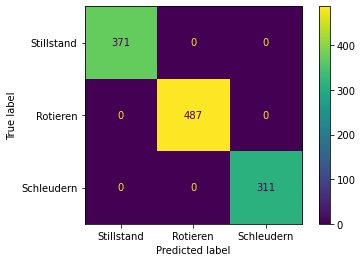

In [175]:
model_trommel = model(df_fft_trommel, ["Stillstand", "Rotieren", "Schleudern"])

(MLPClassifier(alpha=0.03, max_iter=5000), StandardScaler())

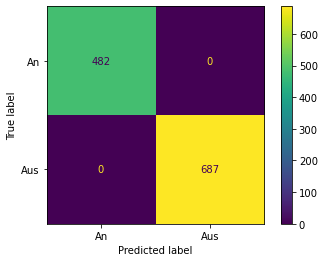

In [174]:
model(df_fft_pumpe, ["An", "Aus"])

In [176]:
df_fft_pumpe

,0,1
0,0.0,0.000305
1,0.0,0.005304
2,0.0,0.005319
3,0.0,0.003996
4,0.0,0.002191
...,...,...
4671,1.0,1.002779
4672,1.0,1.004985
4673,1.0,1.003236
4674,1.0,1.002434
